In [1]:
# !pip3 install torch torchvision torchaudio
# !pip3 install tqdm

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import ast
import warnings
import os
import tqdm
import json
import logging
import torch

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from torch.utils.data import RandomSampler
from tqdm import tqdm as tq
from tqdm.auto import tqdm
from torch.utils.data import DataLoader , IterableDataset , Dataset
from torch.optim import AdamW
from transformers import get_scheduler
from transformers import BertTokenizer, BertLMHeadModel, AutoConfig

/kaggle/input/lmsys-chatbot-arena/sample_submission.csv
/kaggle/input/lmsys-chatbot-arena/train.csv
/kaggle/input/lmsys-chatbot-arena/test.csv


In [3]:
df = pd.read_csv("/kaggle/input/lmsys-chatbot-arena/train.csv")
df.head(10)
print(df.shape)

(57477, 9)


In [4]:
try:
    dfn = pd.read_csv("/kaggle/working/dfn.csv")
    print("dfn loaded")
except:
    warnings.filterwarnings("ignore")
    train_prompt_response_winner = []
    total_rows_processed = 0
    rows_failed = 0
    for row in tq(df.iterrows()):
        try:
            prompts = ast.literal_eval(row[1]["prompt"])

            model_a = row[1]["model_a"]
            model_b = row[1]["model_b"]

            response_a = ast.literal_eval(row[1]["response_a"])
            response_b = ast.literal_eval(row[1]["response_b"])

            winner_model_a = int(row[1]["winner_model_a"])
            winner_model_b = int(row[1]["winner_model_b"])

            winner = "N"

            if winner_model_a == 1:
                winner = "A"
            elif winner_model_b == 1:
                winner = "B"
            for idx, p in enumerate(prompts):
                train_prompt_response_winner.append(
                    {
                        "id": row[1]['id'] ,
                        "prompt": p,
                        "model_a": model_a,
                        "model_b": model_b,
                        "model_a_response": response_a[idx],
                        "model_b_response": response_b[idx],
                        "winner": winner,
                    }
                )
            total_rows_processed += 1
        except Exception as e:
            rows_failed += 1
    print(total_rows_processed , rows_failed , len(train_prompt_response_winner))



    ids = []
    prompts = []
    model_a = []
    model_b = []
    winners = []

    failed = 0
    for e in tq(train_prompt_response_winner):
        try:
            _id = e['id']
            prompt = e['prompt'].encode("utf-8").decode("utf-8" , "ignore")
            model_a_response = e['model_a_response'].encode("utf-8").decode("utf-8" , "ignore")
            model_b_response = e['model_b_response'].encode("utf-8").decode("utf-8" , "ignore")
            winner = e['winner']

            ids.append(_id)
            prompts.append(prompt)
            model_a.append(model_a_response)
            model_b.append(model_b_response)
            winners.append(winner)
        except:
            failed += 1
    print(failed)

    dfn = pd.DataFrame(index=None)
    dfn['id'] = ids
    dfn['prompt'] = prompts
    dfn['model_a_answer'] = model_a
    dfn['model_b_answer'] = model_b
    dfn['winner'] = winners

    print(dfn.head(10))

    dfn.to_csv('/kaggle/working/dfn.csv', index=False)
    print("dfn created and saved")

57477it [00:09, 5778.17it/s]


57316 161 70912


100%|██████████| 70912/70912 [00:00<00:00, 151718.40it/s]


754
       id                                             prompt  \
0   30192  Is it morally right to try to have a certain p...   
1   53567  What is the difference between marriage licens...   
2   53567  How can I get both of them as quick as possibl...   
3   53567  What is the minimal time to get them? 1 day or...   
4   65089  explain function calling. how would you call a...   
5   96401  How can I create a test set for a very rare ca...   
6  198779  What is the best way to travel from Tel-Aviv t...   
7  292873  Construct a rap battle, in the style of Epic R...   
8  313413                 Why water is not used in bath tub?   
9  370945  "Bacteria is life on Mars but a heartbeat isn'...   

                                      model_a_answer  \
0  The question of whether it is morally right to...   
1  A marriage license is a legal document that al...   
2  If you want to get both a marriage license and...   
3  The minimal time to get a marriage license and...   
4  Function

In [5]:
model = BertLMHeadModel.from_pretrained("google-bert/bert-large-uncased")
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-large-uncased")

unique_ids = dfn.id.unique()

model

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertLMHeadModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-

In [6]:
id_list = []
id_strings = []

for _id in tqdm(unique_ids):
    id_df = dfn[dfn.id == _id]
    id_str = ""
    
    for row in id_df.iterrows():
        prompt = str(row[1]['prompt'])
        
        model_a_answer = str(row[1]['model_a_answer'])
        model_b_answer = str(row[1]['model_b_answer'])
        winner = row[1]['winner']

        if winner == "A":
            id_str += prompt + "\n" + model_a_answer +'\n'
        if winner == "B":
            id_str += prompt + "\n" + model_b_answer +'\n'
        if winner == "N":
            id_str += prompt + "\n" + model_a_answer +'\n' + model_b_answer + '\n'
    
    if len(id_str) > 10:
        id_strings.append(str(id_str))
        id_list.append(str(_id))

cut = int(len(id_strings) * 0.2)

id_strings_train = id_strings[0:len(id_strings) - cut]
id_strings_test = id_strings[cut:]

  0%|          | 0/56759 [00:00<?, ?it/s]

In [7]:
class DocsDataset(Dataset):
    def tokenize_ans(self , examples):
        return tokenizer(examples, padding='max_length' , max_length=512 , truncation=True , return_tensors='pt')
    
    def __init__(self, str_list):
        self.str_list = str_list

    def __len__(self):
        return len(self.str_list)
        
    def __getitem__(self , idx):
        tokenized_str_map = self.tokenize_ans(self.str_list[idx])
        tokenized_str_map['labels'] = tokenized_str_map['input_ids']
        return tokenized_str_map
    
class EarlyStopping():
    def ppl(self , sample):
        max_length = 512
        stride = 256
        seq_len = sample['input_ids'].size(1)
        nlls = []
        prev_end_loc = 0
        for begin_loc in range(0, seq_len, stride):
            
            end_loc = min(begin_loc + max_length, seq_len)
            trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
            input_ids = sample['input_ids'][:, begin_loc:end_loc].to(self.device)
            target_ids = input_ids.clone()
            attention_mask = sample['attention_mask'][:, begin_loc:end_loc].to(self.device)
            attention_masks = attention_mask.clone()
            target_ids[:, :-trg_len] = -100

            with torch.no_grad():
                outputs = self.model(input_ids, labels=target_ids , attention_mask=attention_masks)

                # loss is calculated using CrossEntropyLoss which averages over valid labels
                # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
                # to the left by 1.
                neg_log_likelihood = outputs.loss

            nlls.append(neg_log_likelihood)

            prev_end_loc = end_loc
            if end_loc == seq_len:
                break

        ppl = torch.exp(torch.stack(nlls).mean())
        return ppl
    
    def evaluate(self):
        print("Eval...")
        for idx , sample in enumerate(self.eval_dataloader):
            sample = {k: torch.squeeze(v , 1) for k, v in sample.items()}
            self.ppls.append(self.ppl(sample))
            if idx % 200 == 0:
                print("Eval PPL at iteration " + str(idx)+ ": " + str(self.ppls[-1]))
    
    def __init__(self, model, device, eval_dataloader, min_loss = 0.9):
        self.model = model
        self.device = device
        self.eval_dataloader = eval_dataloader
        self.min_loss = min_loss
        self.early_stop = False
        self.ppls = []
        self.min_loss_met = False
        
    def __call__(self , loss):
        self.evaluate()
        if loss <= self.min_loss:
            self.min_loss_met = True
        if (loss > self.min_loss) and (self.min_loss_met is True):
            self.early_stop = True

dataset_docs_train = DocsDataset(id_strings_train)
dataset_docs_train_dataloader = DataLoader(dataset_docs_train, shuffle=True, batch_size=4)

dataset_docs_test = DocsDataset(id_strings_test)
sampler = RandomSampler(dataset_docs_test , replacement=True , num_samples=300)
dataset_docs_test_dataloader = DataLoader(dataset_docs_test, shuffle=False, batch_size=4, sampler=sampler)

In [8]:
import gc

gc.collect()
torch.cuda.empty_cache()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

early_stopping = EarlyStopping(model , device , dataset_docs_test_dataloader)

optimizer = AdamW(model.parameters(), lr=4e-5)
num_epochs = 1
num_training_steps = (num_epochs * len(dataset_docs_train_dataloader))//3

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=num_training_steps
)

losses_list = []

print("Training steps: " + str(num_training_steps))
print("Epochs: " + str(num_epochs))
print("Device: " + str(device))

Training steps: 3784
Epochs: 1
Device: cuda


In [9]:
progress_bar = tqdm(range(num_training_steps))
model.train()

for epoch in range(num_epochs):
    print('-' * 30)
    print("Epoch: " + str(epoch + 1))
    if early_stopping.early_stop is False:
        for idx , batch in enumerate(dataset_docs_train_dataloader):
            if early_stopping.early_stop is False:
                batch = {k: torch.squeeze(v , 1).to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                if (idx % 200 == 0) or (idx < 30):
                    losses_list.append(loss.item())
                    
                if ((idx % 500 == 0) and idx >1):
                    print("Iteration: " + str(idx) , "Loss: " + str(loss.item()))
                    early_stopping(loss.item())

                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
                progress_bar.update(1)

            else:
                print('-'*20)
                print("Early Stop Summary:")
                print("Early Stop @ Epoch: " + str(epoch + 1))
                print("Iteration " + str(idx))
                print("Most recent loss of: " + str(loss.item()))
                print('-'*20)
                break
    else:
        break

  0%|          | 0/3784 [00:00<?, ?it/s]

------------------------------
Epoch: 1
Iteration: 500 Loss: 0.2933810353279114
Eval...
Eval PPL at iteration 0: tensor(1.3925, device='cuda:0')
Iteration: 1000 Loss: 0.113202765583992
Eval...
Eval PPL at iteration 0: tensor(1.0920, device='cuda:0')
Iteration: 1500 Loss: 0.012647610157728195
Eval...
Eval PPL at iteration 0: tensor(1.0077, device='cuda:0')
Iteration: 2000 Loss: 0.011539923958480358
Eval...
Eval PPL at iteration 0: tensor(1.0029, device='cuda:0')
Iteration: 2500 Loss: 0.005815850105136633
Eval...
Eval PPL at iteration 0: tensor(1.0046, device='cuda:0')
Iteration: 3000 Loss: 0.0032112407498061657
Eval...
Eval PPL at iteration 0: tensor(1.0080, device='cuda:0')
Iteration: 3500 Loss: 0.035938095301389694
Eval...
Eval PPL at iteration 0: tensor(1.0015, device='cuda:0')
Iteration: 4000 Loss: 0.0009086294448934495
Eval...
Eval PPL at iteration 0: tensor(1.0038, device='cuda:0')
Iteration: 4500 Loss: 0.0025744426529854536
Eval...
Eval PPL at iteration 0: tensor(1.0024, device='

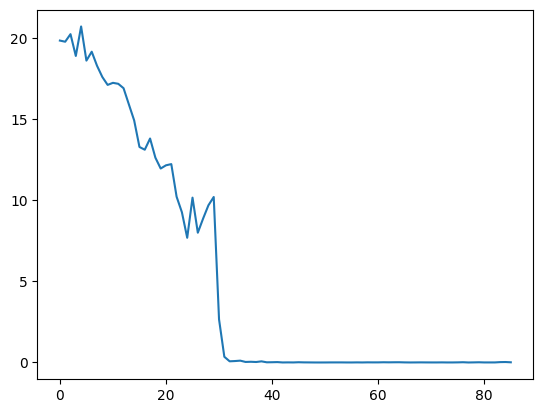

In [10]:
import matplotlib.pyplot as plt
plt.plot(losses_list)
plt.show()